In [2]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2020-08-01", end="2025-08-06", interval="1d")
eth = yf.download("ETH-USD", start="2020-08-01", end="2025-08-06", interval="1d")

# 保留常用列并保存
btc = btc[['Open','High','Low','Close','Volume']].rename(columns=str.lower).reset_index().rename(columns={'Date':'date'})
eth = eth[['Open','High','Low','Close','Volume']].rename(columns=str.lower).reset_index().rename(columns={'Date':'date'})

btc.to_csv("BTC_5y_daily.csv", index=False)
eth.to_csv("ETH_5y_daily.csv", index=False)
print("OK:", btc.shape, eth.shape)

/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_50192/1155204354.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-08-01", end="2025-08-06", interval="1d")
[*********************100%***********************]  1 of 1 completed
/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_50192/1155204354.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2020-08-01", end="2025-08-06", interval="1d")
[*********************100%***********************]  1 of 1 completed

OK: (1831, 6) (1831, 6)


In [ ]:
import pandas as pd
import numpy as np

# ---- 0) 先把 date 变成 datetime，并排序（MultiIndex 访问法）----
btc[('date','')] = pd.to_datetime(btc[('date','')]).dt.floor('D')
eth[('date','')] = pd.to_datetime(eth[('date','')]).dt.floor('D')
btc = btc.sort_values(('date','')).reset_index(drop=True)
eth = eth.sort_values(('date','')).reset_index(drop=True)

# ---- 1) 统一日期（交集），保证两边同一组 trading days ----
common = np.intersect1d(btc[('date','')].values, eth[('date','')].values)
btc = btc[btc[('date','')].isin(common)].reset_index(drop=True)
eth = eth[eth[('date','')].isin(common)].reset_index(drop=True)

# ---- 2) 设定研究窗口（t），以及 t-1 / t-2 的窗口 ----
start_t = pd.Timestamp('2020-08-03')
end_t   = pd.Timestamp('2025-08-03')

mask_t   = (eth[('date','')] >= start_t) & (eth[('date','')] <= end_t)
mask_t1  = (eth[('date','')] >= start_t - pd.Timedelta(days=1)) & (eth[('date','')] <= end_t - pd.Timedelta(days=1))
mask_t2  = (eth[('date','')] >= start_t - pd.Timedelta(days=2)) & (eth[('date','')] <= end_t - pd.Timedelta(days=2))

# ---- 3) 逐列提取（注意：每次都 reset_index(drop=True)）----
# 目标 y = ETH_t
Eth_y_t   = eth.loc[mask_t,  ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)

# A 的四列：ETH_{t-1}, ETH_{t-2}, BTC_{t-1}, BTC_{t-2}
Eth_y_t_1 = eth.loc[mask_t1, ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)
Eth_y_t_2 = eth.loc[mask_t2, ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)

Btc_y_t_1 = btc.loc[mask_t1, ('close','btc-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)
Btc_y_t_2 = btc.loc[mask_t2, ('close','btc-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)


A = np.hstack([Eth_y_t_1/1000, Eth_y_t_2/1000, Btc_y_t_1/100000, Btc_y_t_2/100000]).astype(float)
y = Eth_y_t.astype(float) / 1000

print("A shape:", A.shape, " y shaße:", y.shape)
assert A.shape[0] == y.shape[0]
print(A)


A shape: (1827, 4)  y shape: (1827, 1)
[[0.37067172 0.38519971 0.11053614 0.11759593]
 [0.38629517 0.37067172 0.11246349 0.11053614]
 [0.38987549 0.38629517 0.11205893 0.11246349]
 ...
 [3.69670776 3.80820166 1.15758203 1.17831187]
 [3.48836597 3.69670776 1.13320086 1.15758203]
 [3.39274121 3.48836597 1.12526914 1.13320086]]


In [4]:
# ---- 1) 切分 80% / 20% ----
n = A.shape[0]
split_idx = int(n * 0.8)
A_train, A_test = A[:split_idx], A[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ---- 2) 初始化参数 ----
beta = 0.8
P = np.identity(A.shape[1])
theta = np.zeros((A.shape[1], 1))

# ---- 3) 在训练集上递推更新 theta ----
for row, y_t in zip(A_train, y_train.flatten()):
    row = row.reshape(-1, 1)
    newsample = row @ row.T
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P) / (beta + row.T @ P @ row))

# ---- 4) 用训练好的模型在测试集上预测 ----
y_pred_test = A_test @ theta

# ---- 5) 对比预测值和真实值 ----
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MSE: {mse:.4f}")
print(f"R² : {r2:.4f}")



MSE: 0.0273
R² : 0.9227


RMSE: 5.3159
R² : -79.0067


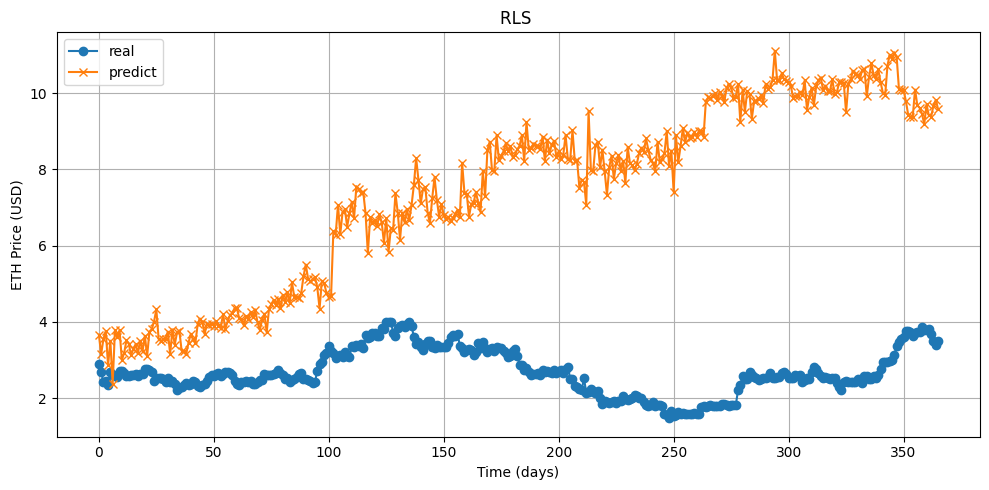

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ---- 1) 切分 80% / 20% ----
n = A.shape[0]
split_idx = int(n * 0.8)
A_train, A_test = A[:split_idx], A[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ---- 2) 初始化参数 ----
beta = 0.3
P = np.identity(A.shape[1])
theta = np.zeros((A.shape[1], 1))

# ---- 3) 在训练集上递推更新 theta ----
for row, y_t in zip(A_train, y_train.flatten()):
    row = row.reshape(-1, 1)
    newsample = row @ row.T
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P) / (beta + row.T @ P @ row))

# ---- 4) 用训练好的模型在测试集上预测 ----
y_pred_test = A_test @ theta

# ---- 5) 评估
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f"RMSE: {rmse:.4f}")
print(f"R² : {r2:.4f}")

# ---- 6) 绘图
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="real", marker='o')
plt.plot(y_pred_test, label="predict", marker='x')
plt.title("RLS ")
plt.xlabel("Time (days)")
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RMSE: 0.1347
R² : 0.9486


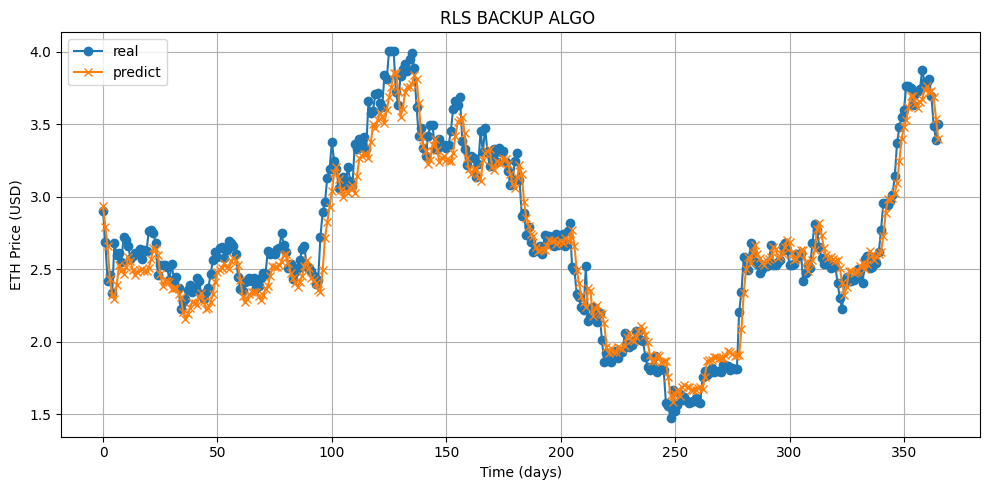

In [6]:
# NLMS
n = A.shape[0]
split_idx = int(n * 0.8)
A_train, A_test = A[:split_idx], A[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

eta = 0.1
theta = np.array([0, 0, 0, 0]).reshape(-1, 1)
NLMStheta = []

for row, y_t in zip(A_train, y_train):
    row = row.reshape(-1, 1)   
    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)


# ---- 4) 用训练好的模型在测试集上预测 ----
y_pred_test = A_test @ theta

# ---- 5) 评估
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f"RMSE: {rmse:.4f}")
print(f"R² : {r2:.4f}")
 

# ---- 6) 绘图
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="real", marker='o')
plt.plot(y_pred_test, label="predict", marker='x')
plt.title("RLS BACKUP ALGO ")
plt.xlabel("Time (days)")
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()